In [1]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image

# generate dataset

In [2]:
print(os.listdir('input/data/'))

['test', 'train']


In [3]:
folder_benign_train = 'input/data/train/benign'
folder_malignant_train = 'input/data/train/malignant'

folder_benign_test = 'input/data/test/benign'
folder_malignant_test = 'input/data/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Load in training pictures 
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')

# Load in testing pictures
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')

# Create labels
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])


# Merge data 
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)

# Shuffle data
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]



(2637, 224, 224, 3) (2637,)


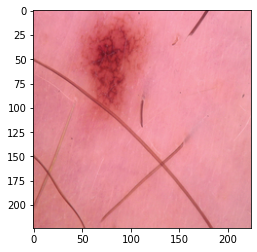

In [4]:
print(X_train.shape, y_train.shape)
plt.imshow(X_train[1])

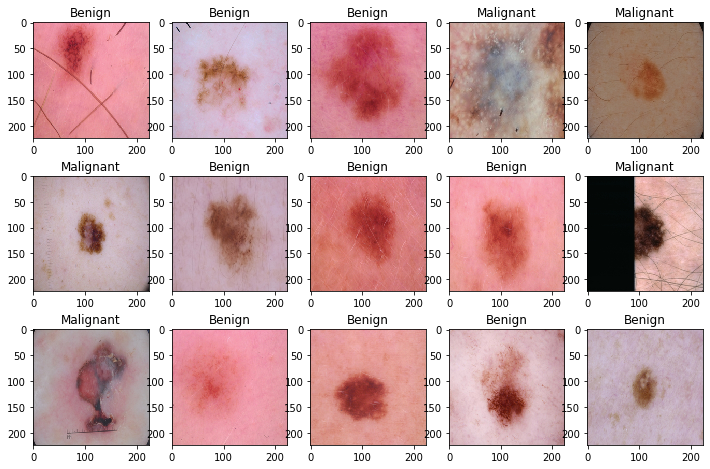

In [5]:
# Display first 15 images of moles, and how they are classified
w=40
h=30
fig=plt.figure(figsize=(12, 8))
columns = 5
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation='nearest')
plt.show()

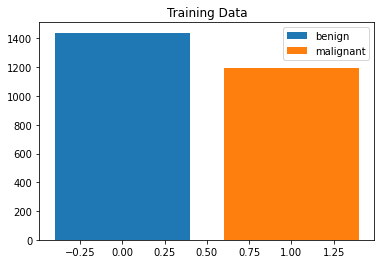

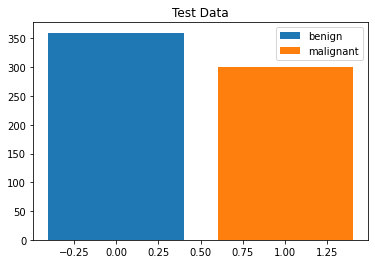

In [6]:
plt.bar(0, y_train[np.where(y_train == 0)].shape[0], label = 'benign')
plt.bar(1, y_train[np.where(y_train == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Training Data")
plt.show()

plt.bar(0, y_test[np.where(y_test == 0)].shape[0], label = 'benign')
plt.bar(1, y_test[np.where(y_test == 1)].shape[0], label = 'malignant')
plt.legend()
plt.title("Test Data")
plt.show()

# data loader

In [7]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms, models
from pathlib import Path
import cv2
from PIL import Image, ImageDraw

In [8]:
class MyDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        self.data = data
        self.labels = labels
        self.transform = transform
 
    def __len__(self):
        # 返回数据集的数据数量
        return self.data.shape[0]
 
    def __getitem__(self, index):
        single_label = self.labels[index]
        img = self.data[index]
        if self.transform:
            PIL_image = Image.fromarray(np.uint8(img))
            img = self.transform(PIL_image)
        return (img, single_label)

In [9]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128),
    transforms.ToTensor(),
])

transform_test = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop(128),
    transforms.ToTensor(),
])

In [10]:
X_train_nor = X_train/255.
X_test_nor = X_test/255.

In [11]:
traindata = MyDataset(X_train_nor, y_train, transform = transform_train)
train_loader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)

testdata = MyDataset(X_test_nor, y_test, transform = transform_train)
test_loader = torch.utils.data.DataLoader(traindata, batch_size=64, shuffle=True)

print("====End loading training and test data=====")

====End loading training and test data=====


# generate feature

In [12]:
from PIL import Image, ImageDraw
import os
from skimage.transform import resize
from skimage.io import imread
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix

%matplotlib inline
import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from torch.autograd import Variable
import torch.utils.data as data
import re

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)

# Remove last softmax layer for deep feature extraction
model = torch.nn.Sequential(*(list(model.children())[:-1]))
model.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [14]:
flat_data_arr=[] #input array
target_arr=[] #output array

In [15]:
# Generate deep features from ResNet model by forward pass
def image_feature_loader(dataloader):
    for inputs, labels in dataloader:
        logps = model.forward(inputs.to(device))
        for i in range(len(labels)):
            flat_data_arr.append(np.array(logps[:,:,0,0][i].cpu().detach()))
            target_arr.append(np.array(labels[i].cpu().detach()))


image_feature_loader(train_loader)

In [16]:
# Load data into dataframe and save 
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target

In [17]:
# Save df to csv
df.to_csv('deepfeature_train_all.csv', index=False)

In [18]:
flat_data_arr=[] #input array
target_arr=[] #output array

In [19]:
image_feature_loader(train_loader)
image_feature_loader(test_loader)

In [20]:
# Load data into dataframe and save 
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target

In [21]:
# Save df to csv
df.to_csv('deepfeature_train_eva.csv', index=False)

In [22]:
flat_data_arr=[] #input array
target_arr=[] #output array

In [23]:
image_feature_loader(test_loader)

In [24]:
# Load data into dataframe and save 
flat_data=np.array(flat_data_arr)
target=np.array(target_arr)
df=pd.DataFrame(flat_data) #dataframe
df['Target']=target

In [25]:
# Save df to csv
df.to_csv('deepfeature_test.csv', index=False)

In [41]:
import math 

In [42]:
df = pd.read_csv('deepfeature_train_all.csv')
thresholds = 0
df["feature_sum"] = df.iloc[:,:-1].sum(axis=1)
df = df.sort_values(by="feature_sum")
cls = 0
for label in df["Target"]:
    if label != cls:
        thresholds += 1
        cls = label

print("There are", thresholds, "thresholds in the dataset")
print("This translates to a dataset MEC of", math.log(thresholds, 2) * 2048, "bits")

There are 1237 thresholds in the dataset
This translates to a dataset MEC of 21038.345799631606 bits


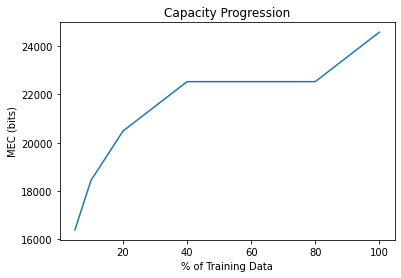

In [43]:
import matplotlib.pyplot as plt
import numpy as np

# This block updated 5/13/2022 7:09AM
plt.plot([5,10,20,40,80,100], np.asarray([8,   9,  10,  11,  11,  12]) * 2048);
plt.title("Capacity Progression")
plt.xlabel("% of Training Data")
plt.ylabel("MEC (bits)");

In [44]:
from sklearn.neural_network import MLPClassifier

data = pd.read_csv('deepfeature_train_all.csv')
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
clf = MLPClassifier(
                hidden_layer_sizes=(12,), random_state=42,
                activation='relu')
clf.fit(X,y)
(clf.predict(X) == y).sum() / len(y)

0.6579446340538491

In [46]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv('deepfeature_train_all.csv')
X = data.iloc[:,:-1]
y = data.iloc[:,-1]
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
train_accuracy_list = []
val_accuracy_list = []

for hidden_size in range(1,13):
    print("Now training + evaluating on hidden size", hidden_size)
    clf = MLPClassifier(hidden_layer_sizes=hidden_size, max_iter=500)
    clf.fit(X_train,y_train)
    train_accuracy_list.append((clf.predict(X_train) == y_train).sum() / len(y_train))
    val_accuracy_list.append((clf.predict(X_val) == y_val).sum() / len(y_val))

print(train_accuracy_list)
print(val_accuracy_list)

Now training + evaluating on hidden size 1
Now training + evaluating on hidden size 2
Now training + evaluating on hidden size 3
Now training + evaluating on hidden size 4
Now training + evaluating on hidden size 5
Now training + evaluating on hidden size 6
Now training + evaluating on hidden size 7
Now training + evaluating on hidden size 8
Now training + evaluating on hidden size 9
Now training + evaluating on hidden size 10
Now training + evaluating on hidden size 11
Now training + evaluating on hidden size 12
[0.5538169748696065, 0.6571834992887624, 0.6557610241820768, 0.656235182550972, 0.6586059743954481, 0.6571834992887624, 0.6571834992887624, 0.6567093409198672, 0.6567093409198672, 0.6576576576576577, 0.6581318160265529, 0.6581318160265529]
[0.5151515151515151, 0.6231060606060606, 0.615530303030303, 0.625, 0.5984848484848485, 0.6098484848484849, 0.5946969696969697, 0.6117424242424242, 0.6174242424242424, 0.6212121212121212, 0.6193181818181818, 0.615530303030303]


Text(0.5, 1.0, 'Training for Generalization')

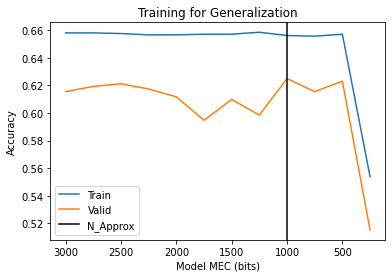

In [53]:
graph, plot = plt.subplots()
plt.plot(list(range(250,250*13, 250)), train_accuracy_list, label="Train")
plt.plot(list(range(250,250*13, 250)), val_accuracy_list, label="Valid")
plt.axvline(x=4*250, color='black', label="N_Approx")
plt.legend()
plot.invert_xaxis()
plt.xlabel("Model MEC (bits)")
plt.ylabel("Accuracy")
plt.title("Training for Generalization")

In [1]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

data = pd.read_csv('deepfeature_train_all.csv')
X = data.iloc[:,:-1]
y = data.iloc[:,-1]

clf = MLPClassifier(hidden_layer_sizes=(4,), max_iter=500)
clf.fit(X,y)
num_correct = (clf.predict(X) == y).sum()
acc = num_correct  / len(y)
print("The training accuracy after choosing the hidden layer size is", acc)
print("The generalization after choosing the hidden layer size is", num_correct / (2050*3))

The training accuracy after choosing the hidden layer size is 0.6579446340538491
The generalization after choosing the hidden layer size is 0.2821138211382114


In [10]:
def perf_measure(y_true, y_pred):
    TP, FP, TN, FN = 0, 0, 0, 0

    for i in range(len(y_true)):
        if y_true[i] == 1 and y_pred[i] == 1:
           TP += 1
        if y_true[i] == 0 and y_pred[i] == 1:
           FP += 1
        if y_true[i] == 0 and y_pred[i] == 0:
           TN += 1
        if y_true[i] == 1 and y_pred[i] == 0:
           FN += 1

    return TP, FP, TN, FN

In [13]:
tn, fp, fn, tp = perf_measure(y, clf.predict(X))
tn, fp, fn, tp

(295, 0, 1440, 902)

In [14]:
tp / (tp + fn)

0.3851409052092229

In [55]:
import pandas as pd
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split

train_data = pd.read_csv('deepfeature_train_all.csv')
X_train = train_data.iloc[:,:-1]
y_train = train_data.iloc[:,-1]

clf = MLPClassifier(hidden_layer_sizes=(4,), max_iter=500)
clf.fit(X_train,y_train)

test_data = pd.read_csv('deepfeature_test.csv')
X_test = test_data.iloc[:,:-1]
y_test = test_data.iloc[:,-1]

num_correct = (clf.predict(X_test) == y_test).sum()
acc = num_correct / len(y_test)
print("The test accuracy after choosing the hidden layer size is " + str(acc))

The test accuracy after choosing the hidden layer size is 0.6150929086082669
